In [1]:
import pandas as pd


cleaned_data = pd.read_csv('cleaned_CKD_dataset.csv')

Performing cross-validation...


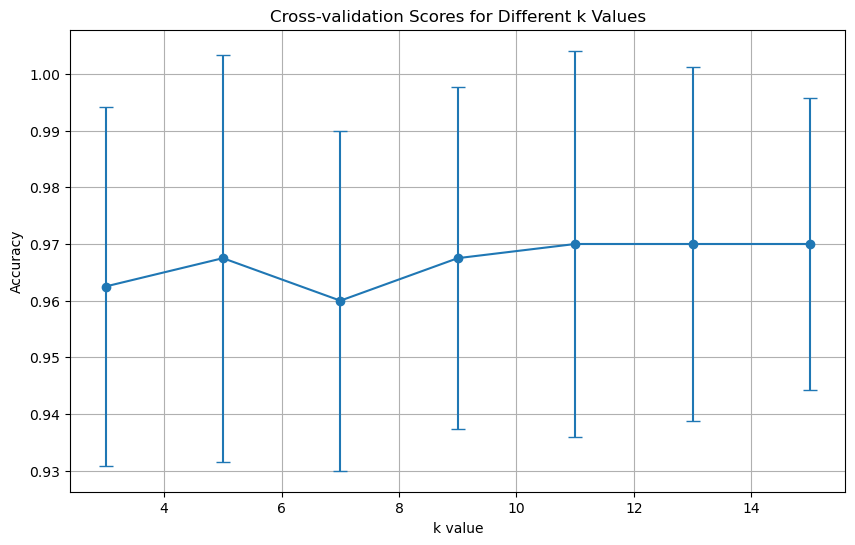


Cross-validation Results:
k=3: Mean=0.9625 (±0.0316)
k=5: Mean=0.9675 (±0.0359)
k=7: Mean=0.9600 (±0.0300)
k=9: Mean=0.9675 (±0.0302)
k=11: Mean=0.9700 (±0.0341)
k=13: Mean=0.9700 (±0.0312)
k=15: Mean=0.9700 (±0.0257)

Optimal k value: 13

Training final model with optimal k...

Final Model Accuracy: 0.9875

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



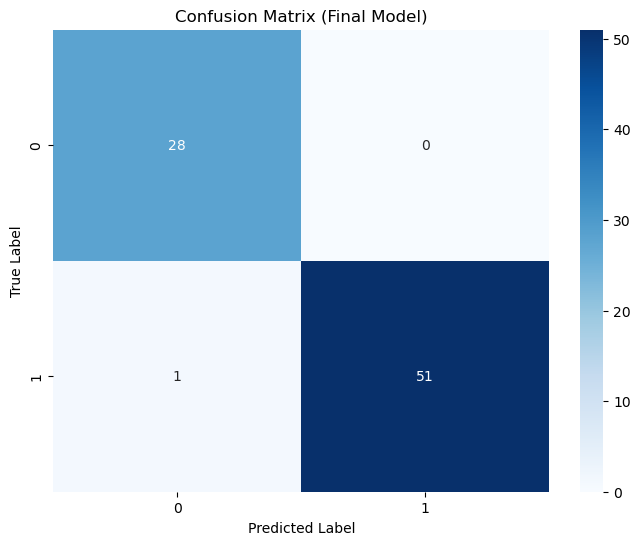

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class DistanceWeightedKNN:
    def __init__(self, k=3, weight_type='inverse'):
        self.k = k
        self.weight_type = weight_type
        
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
    def calculate_weights(self, distances):
        if self.weight_type == 'inverse':
            weights = 1 / (distances + 1e-10)
        else:  # exponential
            weights = np.exp(-distances)
        return weights
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        
        for sample in X:
            distances = np.sqrt(np.sum((self.X_train - sample) ** 2, axis=1))
            k_nearest_indices = np.argsort(distances)[:self.k]
            k_nearest_distances = distances[k_nearest_indices]
            k_nearest_labels = self.y_train[k_nearest_indices]
            
            weights = self.calculate_weights(k_nearest_distances)
            unique_classes = np.unique(k_nearest_labels)
            class_weights = {cls: np.sum(weights[k_nearest_labels == cls]) 
                           for cls in unique_classes}
            
            prediction = max(class_weights.items(), key=lambda x: x[1])[0]
            predictions.append(prediction)
            
        return np.array(predictions)

def perform_cross_validation(X, y, k_values, n_splits=5):
    """
    Perform k-fold cross-validation for different k values
    
    Parameters:
    X: Features
    y: Target
    k_values: List of k values to try
    n_splits: Number of folds for cross-validation
    """
    cv_scores = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for k in k_values:
        scores = []
        for train_idx, val_idx in kf.split(X):
            # Split data
            X_train_fold = X[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X[val_idx]
            y_val_fold = y[val_idx]
            
            # Train and evaluate model
            model = DistanceWeightedKNN(k=k)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            scores.append(accuracy_score(y_val_fold, y_pred))
            
        cv_scores[k] = scores
    
    return cv_scores

def plot_cv_results(cv_scores):
    """Plot cross-validation results"""
    plt.figure(figsize=(10, 6))
    k_values = list(cv_scores.keys())
    mean_scores = [np.mean(scores) for scores in cv_scores.values()]
    std_scores = [np.std(scores) for scores in cv_scores.values()]
    
    plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='o-', capsize=5)
    plt.xlabel('k value')
    plt.ylabel('Accuracy')
    plt.title('Cross-validation Scores for Different k Values')
    plt.grid(True)
    plt.show()
    
    # Print detailed results
    print("\nCross-validation Results:")
    for k, scores in cv_scores.items():
        print(f"k={k}: Mean={np.mean(scores):.4f} (±{np.std(scores):.4f})")

def main():
    # Load data
    data = pd.read_csv('cleaned_CKD_dataset.csv')
    X = data.drop('Class', axis=1)
    y = data['Class']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define k values to try
    k_values = [3, 5, 7, 9, 11, 13, 15]
    
    # Perform cross-validation
    print("Performing cross-validation...")
    cv_scores = perform_cross_validation(X_scaled, y.values, k_values)
    
    # Plot results
    plot_cv_results(cv_scores)
    
    # Find optimal k
    mean_scores = {k: np.mean(scores) for k, scores in cv_scores.items()}
    optimal_k = max(mean_scores.items(), key=lambda x: x[1])[0]
    print(f"\nOptimal k value: {optimal_k}")
    
    # Train final model with optimal k
    print("\nTraining final model with optimal k...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    final_model = DistanceWeightedKNN(k=optimal_k)
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    
    # Evaluate final model
    print(f"\nFinal Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Final Model)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return final_model, scaler

if __name__ == "__main__":
    model, scaler = main()